In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# 데이터 읽기 및 전처리
df = pd.read_csv('/content/Baltic_Dry_Index_Historical_Data.csv')
df = df[['Date', 'Price']]
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.set_index('Date', inplace=True)
df = df.dropna()

# 'Price' 열의 쉼표 제거 및 float로 변환
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# 날짜를 오름차순으로 정렬
df = df.sort_index()

# 데이터 정규화
scaler_BDI = MinMaxScaler()
df['Price'] = scaler_BDI.fit_transform(df[['Price']])

print(df.head())


               Price
Date                
2010-01-04  0.531716
2010-01-05  0.555970
2010-01-06  0.553918
2010-01-07  0.533396
2010-01-08  0.531716


In [ ]:
# Google Colab에 NanumGothic 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# matplotlib.font_manager 임포트
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 설치된 폰트 확인 및 matplotlib에 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

print("폰트 설정 완료")


폰트 설정 완료


In [ ]:
def split_dataset(df, train_size=0.7, val_size=0.15):
    train_end = int(len(df) * train_size)
    val_end = int(len(df) * (train_size + val_size))
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, val, test

# 수입 데이터 분할
train_BDI, val_BDI, test_BDI = split_dataset(df)



In [ ]:
def create_dataset(df, seq_length=12):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df.iloc[i:i+seq_length])
        y.append(df.iloc[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

seq_length = 12
X_train_BDI, y_train_BDI = create_dataset(train_BDI, seq_length)
X_val_BDI, y_val_BDI = create_dataset(val_BDI, seq_length)
X_test_BDI, y_test_BDI = create_dataset(test_BDI, seq_length)

# 데이터를 명시적으로 float 타입으로 변환
X_train_BDI = np.expand_dims(X_train_BDI.astype(np.float32), axis=2)
X_val_BDI = np.expand_dims(X_val_BDI.astype(np.float32), axis=2)
X_test_BDI = np.expand_dims(X_test_BDI.astype(np.float32), axis=2)




In [ ]:
# LSTM 모델 정의
def build_lstm_model():
    model = keras.Sequential()
    model.add(layers.LSTM(50, activation='relu', input_shape=(seq_length, 1)))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
# 수입 모델 훈련
model_BDI = build_lstm_model()
callbacks_BDI = [keras.callbacks.ModelCheckpoint("BDI_lstm_model.h5", save_best_only=True)]
history_BDI = model_BDI.fit(X_train_BDI, y_train_BDI, epochs=50, validation_data=(X_val_BDI, y_val_BDI), callbacks=callbacks_BDI)
model_BDI = keras.models.load_model("BDI_lstm_model.h5")

Epoch 1/50
79/79 [==============================] - 3s 15ms/step - loss: 0.0048 - mae: 0.0398 - val_loss: 0.0023 - val_mae: 0.0338
Epoch 2/50
12/79 [===>..........................] - ETA: 0s - loss: 5.0603e-04 - mae: 0.0165

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 1s 13ms/step - loss: 4.1061e-04 - mae: 0.0145 - val_loss: 0.0019 - val_mae: 0.0307
Epoch 3/50
79/79 [==============================] - 1s 13ms/step - loss: 3.6467e-04 - mae: 0.0138 - val_loss: 0.0015 - val_mae: 0.0286
Epoch 4/50
79/79 [==============================] - 1s 12ms/step - loss: 3.1182e-04 - mae: 0.0127 - val_loss: 0.0013 - val_mae: 0.0269
Epoch 5/50
79/79 [==============================] - 1s 8ms/step - loss: 2.8183e-04 - mae: 0.0122 - val_loss: 0.0010 - val_mae: 0.0240
Epoch 6/50
79/79 [==============================] - 1s 9ms/step - loss: 2.3760e-04 - mae: 0.0112 - val_loss: 8.2307e-04 - val_mae: 0.0214
Epoch 7/50
79/79 [==============================] - 1s 8ms/step - loss: 1.8891e-04 - mae: 0.0100 - val_loss: 7.5019e-04 - val_mae: 0.0201
Epoch 8/50
79/79 [==============================] - 1s 8ms/step - loss: 1.8745e-04 - mae: 0.0100 - val_loss: 7.4060e-04 - val_mae: 0.0200
Epoch 9/50
79/79 [==============================] - 1s 8ms

17/17 [==============================] - 0s 4ms/step


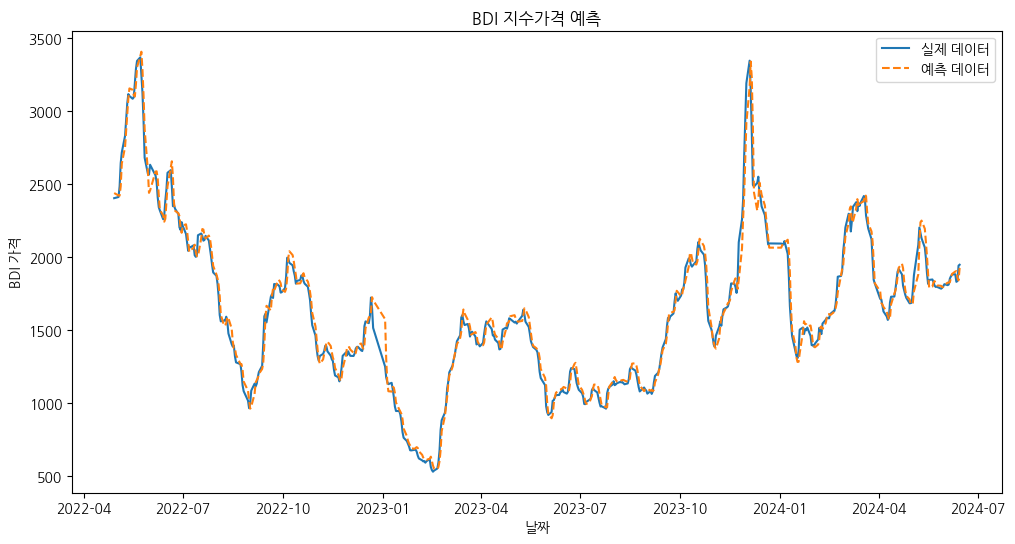

In [ ]:
# 모델 평가 및 시각화 함수
def evaluate_and_plot(model, X_test, y_test, scaler, df, title):
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test_inv, label='실제 데이터')
    plt.plot(df.index[-len(y_test):], y_pred_inv, label='예측 데이터', linestyle='--')
    plt.xlabel('날짜')
    plt.ylabel('BDI 가격')
    plt.title(title)
    plt.legend()
    plt.show()

# 수입 모델 평가 및 시각화
evaluate_and_plot(model_BDI, X_test_BDI, y_test_BDI, scaler_BDI, df, 'BDI 지수가격 예측')
